In [1]:
# import libraries

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors
import numpy as np
import seaborn as sns
import statistics

from sklearn.linear_model import LinearRegression
from imblearn.ensemble import BalancedRandomForestClassifier

from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import LeaveOneGroupOut

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

from sklearn import metrics
from sklearn.metrics import confusion_matrix

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.decomposition import PCA

from statsmodels.stats.outliers_influence import variance_inflation_factor

import shap
from shap import TreeExplainer, Explanation
from shap.plots import waterfall

# load and merge data


In [2]:
sheet_names = ['Subject characteristics', 'PCs', 'GA parameters', 'Muscle impairments']
source_path = 'data/dataset.xlsx'
dfs = [pd.read_excel(source_path, sheet_name = sheet) for sheet in sheet_names]

In [3]:
def merge_dataframes(dfs):
    
    # merge files
    same_cols = ['GC_id',
                'Measurement_id',
                'Patient_id',
                'side',
                'Affected(MA=most affected; A=affected)',
                'Label ']
    
    dfs_1_2 = pd.merge(dfs[0], dfs[1], on=same_cols)
    dfs_1_2_3 = pd.merge(dfs_1_2, dfs[2], on=same_cols)
    merged_df = pd.merge(dfs_1_2_3, dfs[3].drop('Age', axis=1), on=same_cols)
    
    return merged_df

In [4]:
df_unpreprocessed = merge_dataframes(dfs)

# impute missing values by linear regression


In [5]:
def estimate_and_impute_missing_values(MI_feature, input_features, df, df_MIs):
    
        features_train = df.loc[df_MIs[MI_feature].notnull(), input_features]  # where feature is not missing 
        target_train = df.loc[df_MIs[MI_feature].notnull(), MI_feature]        # where feature is not missing
        features_test = df.loc[df_MIs[MI_feature].isna(), input_features]      # where feature is missing
        
        # initialize linear regression model
        lr = LinearRegression()

        # train linear regression model
        lr.fit(features_train, target_train)

        # predict the feature values that are missing
        target_test = lr.predict(features_test)
        
        # check the R2 performance with leave-one-out crossvalidation on training set
        predictions = cross_val_predict(lr, features_train, target_train, cv=LeaveOneOut())
        estimation_performance = metrics.r2_score(target_train, predictions)
        print('crossvalidation performance (R2) using training set for ' + MI_feature + ':')
        print(estimation_performance.round(3))
        print('')

        # imputation: if the R2 > 0, impute with linear regression estimate, otherwise impute with mean
        if (estimation_performance > 0):
            df_MIs.loc[df_MIs[MI_feature].isna(), MI_feature] = target_test
        else:
            mean = df_MIs[MI_feature].mean()
            df_MIs.loc[df_MIs[MI_feature].isna(), MI_feature] = mean
        

        return df_MIs

# preprocessing




In [6]:
def data_preprocessing(df):
    
    # seperate features per type
    y = df['Label '].astype(str)
    df_IDs = df.iloc[:,0:5]
    df_SCs = df.iloc[:,6:13]
    df_PCs = df.iloc[:,13:83]
    df_GAPs = df.iloc[:,83:248]
    df_MIs = df.iloc[:,248:]
    
    # rename categories of the target variable
    y.loc[y == '1'] = 'Mildly affected'
    y.loc[y == '2'] = 'Tiptoeing'
    y.loc[y == '3'] = 'Flexion'
    
    # drop specific variables that will not be used
    df_MIs = df_MIs.drop(['Side (R=0, L=1)'], axis=1)
    df_SCs = df_SCs.drop(['Exon ','LegLength','weight'], axis=1)
    df_IDs = df_IDs.drop(['Affected(MA=most affected; A=affected)'], axis=1)
    
    # select the GPS features from the GAPS, the other GAP features will not be used
    df_GPS = df_GAPs[['GPS_a', 'GPS_m','GPS_p']] 
    
    # change 'Duplication ' to 'Duplication' because they are seen as different categorical values
    df_SCs.loc[df_SCs['Gene variant'] == 'Duplication ', 'Gene variant'] = 'Duplication'
    
    # handle nominal categorical variable
    df_SCs['Gene variant'] = df_SCs['Gene variant'].astype("category")
    df_dummies = pd.get_dummies(df_SCs['Gene variant'])      # one-hot encoding
    df_SCs = pd.concat([df_SCs,df_dummies], axis=1)          # add the dummies to the subject characteristics
    df_SCs = df_SCs.drop(['Gene variant'], axis=1)           # drop the original variable
    
    # delete muscle strength variables that are not normalized and/or not in comparison to the TD children
    for MI_feature_name in df_MIs.columns[16:]:
        if not(MI_feature_name.endswith('Nmkg%')):  
            df_MIs = df_MIs.drop([MI_feature_name], axis=1)
    
    # seperate MIs, rename them, and merge them back so they are grouped per muscle impairment type
    df_contractures = df_MIs[['Hip_add_ROM', 'Hip_ext_ROM','Knee_ext_ROM', 'Ham_ROM' ,'Gastroc_ROM','Soleus_ROM']]
    df_stiffness = df_MIs[['Hip_abd_stiff','Hip_flex_stiff','Knee_flex_stiff','Ham_stiff','RF_stiff','RF_length','Soleus_stiff','Gastroc_stiff']]
    df_strength = df_MIs[['HF_Nmkg%','HA_Nmkg%', 'HE_Nmkg%', 'KE_Nmkg%', 'KF_Nmkg%', 'ADF_Nmkg%','APF_Nmkg%', 'Abdominal_strength ', 'Back_strength ']]
    df_contractures.columns = ['ROM Hip adduction', 'ROM Hip extension', 'ROM Knee extension', 'ROM Hamstrings', 'ROM Gastrocnemius', 'ROM Soleus']
    df_stiffness.columns = ['Hip abductor stiffness', 'Hip flexor stiffness', 'Knee flexor stiffness', 'Hamstring stiffness', 'Rectus femoris stiffness', 'Rectus femoris length', 'Soleus stiffness', 'Gastrocnemius stiffness']
    df_strength.columns = ['Hip flexor strength', 'Hip abductor strength', 'Hip extensor strength', 'Knee extensor strength', 'Knee flexor strength', 'Dorsiflexor strength', 'Plantar flexor strength', 'Abdominal strength', 'Back strength']
    df_MIs = pd.concat([df_strength, df_contractures, df_stiffness], axis=1)
    
    # impute missing values of muscle impairment variables
    df_NANs = df_MIs.isnull().sum()
    MI_features_with_missing_data = list(df_NANs[df_NANs > 0].index)
    MI_features_without_missing_data = list(df_NANs[df_NANs == 0].index)

    input_features =  list(df_SCs[['Age','BMI']].columns) + MI_features_without_missing_data   # input features of the linear regression
    df_full = pd.concat([df_IDs, df_SCs, df_PCs, df_GPS, df_MIs], axis=1) 

    for MI_feature in MI_features_with_missing_data:
        df_MIs = estimate_and_impute_missing_values(MI_feature, input_features, df_full, df_MIs)
    
    # concatenate all preprocessed feature groups that can be used as input features
    df_features = pd.concat([df_SCs, df_PCs, df_GPS, df_MIs], axis=1)
    
    return pd.concat([df_IDs, df_features, y], axis=1)


In [7]:
df_unaggregated = data_preprocessing(df_unpreprocessed)

crossvalidation performance (R2) using training set for Hip flexor strength:
0.552

crossvalidation performance (R2) using training set for Hip abductor strength:
0.412

crossvalidation performance (R2) using training set for Hip extensor strength:
0.386

crossvalidation performance (R2) using training set for Knee extensor strength:
0.533

crossvalidation performance (R2) using training set for Knee flexor strength:
0.272

crossvalidation performance (R2) using training set for Dorsiflexor strength:
0.444

crossvalidation performance (R2) using training set for Plantar flexor strength:
0.363

crossvalidation performance (R2) using training set for Abdominal strength:
0.143

crossvalidation performance (R2) using training set for Back strength:
0.465

crossvalidation performance (R2) using training set for ROM Hip adduction:
0.214

crossvalidation performance (R2) using training set for ROM Hamstrings:
0.228

crossvalidation performance (R2) using training set for Hip abductor stiffnes

# data aggregation

In [8]:
# aggregate all observations of the same measurement session and the same side into one observation
# gait characteristics (PCs & GPS) are averaged for this
df = df_unaggregated.groupby(['Measurement_id', 'side']).aggregate({
                                                 'Measurement_id':'first','Patient_id':'first','side':'first',
                                                 'Age': 'first','BMI': 'first','height': 'first','Deletion': 'first','Duplication': 'first','Frameshift mutation ': 'first','Nonsense mutation': 'first','Point mutation': 'first',
                                                 'STPparameters.PC1': 'first','STPparameters.PC2': 'first','aSagP.PC1':'mean','aCorP.PC1':'mean','aCorP.PC2':'mean','aCorP.PC3':'mean','aTransvP.PC1':'mean','aTransvP.PC2':'mean','aTransvP.PC3':'mean','aSagH.PC1':'mean','aSagH.PC2':'mean','aCorH.PC1':'mean','aCorH.PC2':'mean','aSagK.PC1':'mean','aSagK.PC2':'mean',
                                                 'aSagK.PC3':'mean','aSagA.PC1':'mean','aTransvF.PC1':'mean','aTransvF.PC2':'mean','mSagH.PC1':'mean',
                                                 'mSagH.PC2':'mean','mSagH.PC3':'mean','mSagH.PC4':'mean','mSagH.PC5':'mean','mSagH.PC6':'mean','mSagH.PC7':'mean','pH.PC1':'mean','pH.PC2':'mean','pH.PC3':'mean','pH.PC4':'mean','pH.PC5':'mean','pH.PC6':'mean','pH.PC7':'mean','pH.PC8':'mean','pH.PC9':'mean',
                                                 'pH.PC10':'mean','mSagK.PC1':'mean','mSagK.PC2':'mean','mSagK.PC3':'mean','mSagK.PC4':'mean','mSagK.PC5':'mean','pK.PC1':'mean','pK.PC2':'mean','pK.PC3':'mean',
                                                 'pK.PC4':'mean','pK.PC5':'mean','pK.PC6':'mean','pK.PC7':'mean','pK.PC8':'mean','mSagA.PC1':'mean','mSagA.PC2':'mean','mSagA.PC3':'mean','mSagA.PC4':'mean','mSagA.PC5':'mean','mSagA.PC6':'mean','pA.PC1':'mean','pA.PC2':'mean','pA.PC3':'mean','pA.PC4':'mean','pA.PC5':'mean','pA.PC6':'mean', 'pA.PC7':'mean','pA.PC8':'mean',
                                                 'pA.PC9':'mean','pA.PC10':'mean','aSagT.PC1':'mean','aCorT.PC1':'mean','aCorT.PC2':'mean', 'aTransvT.PC1':'mean','aTransvT.PC2':'mean','GPS_a':'mean','GPS_m':'mean','GPS_p':'mean',
                                                 'Hip flexor strength':'first','Hip abductor strength':'first','Hip extensor strength':'first','Knee extensor strength':'first','Knee flexor strength':'first','Dorsiflexor strength':'first',
                                                 'Plantar flexor strength':'first','Abdominal strength':'first','Back strength':'first','ROM Hip adduction':'first','ROM Hip extension':'first','ROM Knee extension':'first','ROM Hamstrings':'first','ROM Gastrocnemius':'first','ROM Soleus':'first','Hip abductor stiffness':'first','Hip flexor stiffness':'first',
                                                 'Knee flexor stiffness':'first','Hamstring stiffness':'first','Rectus femoris stiffness':'first','Rectus femoris length':'first','Soleus stiffness':'first','Gastrocnemius stiffness':'first','Label ':'first'
                                                }, index=False)
df = pd.DataFrame(df.values, columns = df.columns)                # to get normal indexes 
print('shape of aggregated dataframe: ' + str(df.shape))       

shape of aggregated dataframe: (274, 108)


# separate features

In [9]:
IDs = df.iloc[:,0:3]      #  measurement_id, patient_id, side
X = df.iloc[:,3:107]      #  input features
y = df['Label ']         

In [10]:
# separate input features per type
df_SCs = X.iloc[:,0:8]
df_PCs = X.iloc[:,8:78]
df_GPS = X.iloc[:,78:81]
df_MIs = X.iloc[:,81:]

In [11]:
# construct groups of MIs for PCA
df_Hip_a = df_MIs[['ROM Hip adduction', 'Hip abductor stiffness']]
df_Hip_e = df_MIs[['ROM Hip extension','Hip flexor stiffness']] 
df_Knee = df_MIs[['ROM Knee extension','Knee flexor stiffness']] 
df_Ham = df_MIs[['ROM Hamstrings','Hamstring stiffness']] 
df_Gastroc_soleus = df_MIs[['ROM Gastrocnemius','Gastrocnemius stiffness', 'ROM Soleus','Soleus stiffness']] 
df_RF = df_MIs[['Rectus femoris stiffness', 'Rectus femoris length']] 
df_strength_Upper = df_MIs[['Abdominal strength','Back strength']]
df_strength_Hip_knee = df_MIs[['Hip flexor strength', 'Hip abductor strength', 'Hip extensor strength','Knee extensor strength', 'Knee flexor strength']]
df_strength_Ankle = df_MIs[['Dorsiflexor strength', 'Plantar flexor strength']]

In [12]:
# selection of actionable features
X_actionable = pd.concat([df_SCs['BMI'], df_MIs], axis=1)     # for model with only actionable features

# PCA

In [13]:
def pca(features_to_transform, feature_name):
    
    # standardization of original features
    X_scaled = StandardScaler().fit_transform(features_to_transform)

    # PCA retaining all principal components (1)
    n_all_components = features_to_transform.shape[1]
    pca_1 = PCA(n_components = n_all_components)
    pca_1_features = pca_1.fit_transform(X_scaled)
    
    eigenvalues_1 = pca_1.explained_variance_
    eigenvectors_1 = pca_1.components_.T
    
    # contruct of dataframe with all PCs
    PC_names_1 = []    # to store the names of each PC
    for i in range(n_all_components):
        PC_names_1.append(feature_name + '_PC' + str(i+1))                 # PCs are numbered
    pca_1_df = pd.DataFrame(data = pca_1_features, columns= PC_names_1)
    
    # construct dataframe with eigenvectors
    df_eigenvectors_1 = pd.DataFrame(eigenvectors_1, columns=PC_names_1, index=features_to_transform.columns)
    
    # contruct dataframe with loadings
    loadings_1 = eigenvectors_1 * np.sqrt(eigenvalues_1)
    df_loadings_1 = pd.DataFrame(loadings_1, columns=PC_names_1, index=features_to_transform.columns)
    
    
    '''
    print('correlation matrix: ')
    print(features_to_transform.corr())
    
    print('eigenvalues: ')
    print(eigenvalues_1)
    
    print('explained variance ratios: ')
    print(pca_1.explained_variance_ratio_)
    
    print('eigenvectors: ')
    print(df_eigenvectors_1)
    
    print('loadings: ')
    print(df_loadings_1)
    
    '''
    
    # calculate optimal number of PCs (= nr of PCs with an eigenvalue > 1)
    large_evs = [ev for ev in eigenvalues_1 if ev > 1]
    n_optimal_components = len(large_evs)
    
    
    # PCA only retaining the optimal number of principal components  (2)
    pca_2 = PCA(n_components = n_optimal_components)
    pca_2_features = pca_2.fit_transform(X_scaled)
    
    eigenvalues_2 = pca_2.explained_variance_
    eigenvectors_2 = pca_2.components_.T
     
    # contruct new dataframe with PCs
    PC_names_2 = []    # to store the names of the PCs
    if (n_optimal_components == 1):
        PC_names_2.append('PC ' + feature_name)                       # PC does not have to be numbered
    else: 
        for i in range(n_optimal_components):
            PC_names_2.append('PC' + str(i+1) + '_' + feature_name)   # PCs are numbered
    pca_df = pd.DataFrame(data = pca_2_features, columns= PC_names_2)
    
    # construct dataframe with eigenvectors
    df_eigenvectors_2 = pd.DataFrame(eigenvectors_2, columns=PC_names_2, index=features_to_transform.columns)
   
    # construct dataframe with loadings
    loadings_2 = eigenvectors_2 * np.sqrt(eigenvalues_2)
    df_loadings_2 = pd.DataFrame(loadings_2, columns=PC_names_2, index=features_to_transform.columns)
    
    
    print('optimal nr of PCs: ')
    print(n_optimal_components)
    
    '''
    print('eigenvalues: ')
    print(eigenvalues_2)
    '''
    
    print('explained variance ratios: ')
    print(pca_2.explained_variance_ratio_)
    
    '''
    print('eigenvectors: ')
    print(df_eigenvectors_2)
    '''
    
    print('loadings: ')
    print(df_loadings_2)
    
    
    
    return pca_df

In [14]:
df_pca_Hip_a = pca(df_Hip_a, 'hip abduction contractures')

optimal nr of PCs: 
1
explained variance ratios: 
[0.69055898]
loadings: 
                        PC hip abduction contractures
ROM Hip adduction                            0.832519
Hip abductor stiffness                      -0.832519


In [15]:
df_pca_Hip_e = pca(df_Hip_e, 'hip flexion contractures')

optimal nr of PCs: 
1
explained variance ratios: 
[0.83552741]
loadings: 
                      PC hip flexion contractures
ROM Hip extension                        0.915744
Hip flexor stiffness                    -0.915744


In [16]:
df_pca_Knee = pca(df_Knee, 'knee contractures')

optimal nr of PCs: 
1
explained variance ratios: 
[0.92674192]
loadings: 
                       PC knee contractures
ROM Knee extension                -0.964436
Knee flexor stiffness              0.964436


In [17]:
df_pca_Ham = pca(df_Ham, 'hamstring contractures')

optimal nr of PCs: 
1
explained variance ratios: 
[0.75326302]
loadings: 
                     PC hamstring contractures
ROM Hamstrings                       -0.869495
Hamstring stiffness                   0.869495


In [18]:
df_pca_Gastroc_soleus = pca(df_Gastroc_soleus, 'gastrocnemius & soleus contractures')

optimal nr of PCs: 
1
explained variance ratios: 
[0.88667808]
loadings: 
                         PC gastrocnemius & soleus contractures
ROM Gastrocnemius                                     -0.973581
Gastrocnemius stiffness                                0.912540
ROM Soleus                                            -0.929364
Soleus stiffness                                       0.956763


In [19]:
df_pca_RF = pca(df_RF, 'rectus femoris contractures')

optimal nr of PCs: 
1
explained variance ratios: 
[0.63920466]
loadings: 
                          PC rectus femoris contractures
Rectus femoris stiffness                        0.800966
Rectus femoris length                           0.800966


In [20]:
df_pca_strength_Upper = pca(df_strength_Upper, 'upper body weakness')

optimal nr of PCs: 
1
explained variance ratios: 
[0.67313295]
loadings: 
                    PC upper body weakness
Abdominal strength                0.821948
Back strength                     0.821948


In [21]:
df_pca_strength_Hip_Knee = pca(df_strength_Hip_knee, 'hip & knee weakness')

optimal nr of PCs: 
1
explained variance ratios: 
[0.73089175]
loadings: 
                        PC hip & knee weakness
Hip flexor strength                   0.878034
Hip abductor strength                 0.889577
Hip extensor strength                 0.789243
Knee extensor strength                0.918680
Knee flexor strength                  0.799173


In [22]:
df_pca_strength_Ankle = pca(df_strength_Ankle, 'ankle weakness')

optimal nr of PCs: 
1
explained variance ratios: 
[0.71305612]
loadings: 
                         PC ankle weakness
Dorsiflexor strength              0.845972
Plantar flexor strength           0.845972


### construct dataframe for reduced features

In [23]:
# reverse the sign of some PCs (for interpretation purposes)
df_pca_Hip_a_rev = df_pca_Hip_a * -1
df_pca_Hip_e_rev = df_pca_Hip_e * -1
df_pca_strength_Upper_rev = df_pca_strength_Upper * -1
df_pca_strength_Hip_Knee_rev = df_pca_strength_Hip_Knee * -1
df_pca_strength_Ankle_rev = df_pca_strength_Ankle * -1

# concatenate the BMI and the PCs
X_reduced = pd.concat([df_SCs['BMI'], df_pca_strength_Upper_rev,df_pca_strength_Hip_Knee_rev, df_pca_strength_Ankle_rev, df_pca_Hip_a_rev, df_pca_Hip_e_rev, df_pca_Knee, df_pca_Ham, df_pca_Gastroc_soleus, df_pca_RF], axis=1)

# choose final selection for multicollinearity check, model construction, and evaluation

In [24]:
#X_selection = X                 # model with all features
#X_selection = X_actionable      # model with actionable features
X_selection = X_reduced          # reduced model with actionable features after PCA 

# scaling

In [25]:
scaler = MinMaxScaler()
X_selection_scaled_array = scaler.fit_transform(X_selection)
X_selection_scaled = pd.DataFrame(X_selection_scaled_array, columns = X_selection.columns)

In [26]:
X_selection_scaled.describe()

,BMI,PC upper body weakness,PC hip & knee weakness,PC ankle weakness,PC hip abduction contractures,PC hip flexion contractures,PC knee contractures,PC hamstring contractures,PC gastrocnemius & soleus contractures,PC rectus femoris contractures
count,274.000000,274.000000,274.000000,274.000000,274.000000,274.000000,274.000000,274.000000,274.000000,274.000000
mean,0.395540,0.524235,0.520863,0.637357,0.524330,0.649722,0.335917,0.426070,0.408813,0.416012
std,0.235576,0.200028,0.235631,0.200351,0.145998,0.153024,0.187371,0.204830,0.194585,0.246019
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.195633,0.376756,0.303413,0.503417,0.459506,0.584074,0.188917,0.302613,0.257326,0.222038
50%,0.333137,0.503511,0.532145,0.646792,0.510881,0.649991,0.267592,0.394774,0.377548,0.353022
75%,0.605449,0.626756,0.732140,0.783467,0.634265,0.753573,0.442201,0.523377,0.563860,0.652336
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


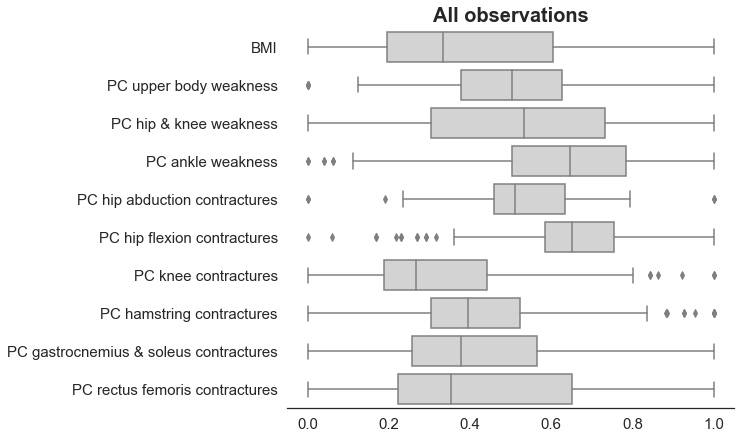

In [27]:
# boxplot with all observations
sns.set_theme(style='white')
plt.figure(figsize=(8,7), facecolor='white')
plot = sns.boxplot(data=X_selection_scaled, color = 'lightgray', orient="h")
plot.set_title('All observations', fontdict={'size': 20}, fontweight="bold")
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
sns.despine(left=True)

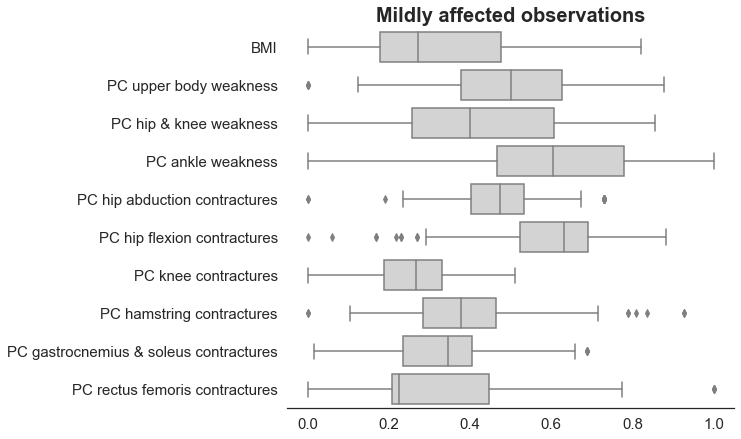

In [28]:
# boxplot with mildly affected observations
sns.set_theme(style='white')
plt.figure(figsize=(8,7), facecolor='white')
MA = X_selection_scaled.loc[y == 'Mildly affected']
plot = sns.boxplot(data=MA, color = 'lightgray', orient="h")
plot.set_title('Mildly affected observations', fontdict={'size': 20}, fontweight="bold")
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
sns.despine(left=True)

# check correlations

<AxesSubplot:>

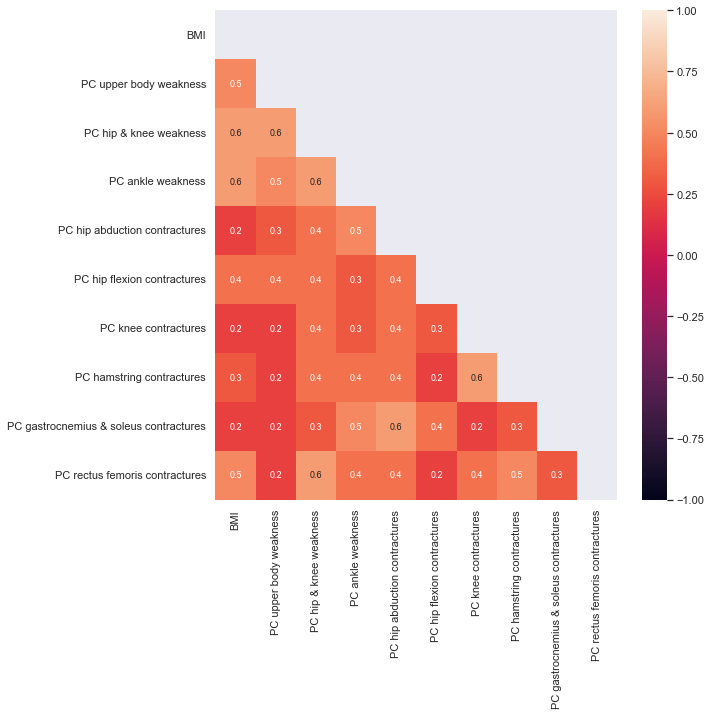

In [29]:
mask = np.triu(np.ones_like(X_selection_scaled.corr(), dtype=bool))   # to only show the bottom triangle of the correlation matrix
corr = X_selection_scaled.corr().round(1)                             # calculate correlations
sns.set(rc={'figure.figsize':(9,9)}) 
sns.heatmap(corr,  annot=True, annot_kws={"size":9}, vmin=-1, vmax=1, mask=mask)     # plot

# check vif scores

In [30]:
def compute_vif(X):
    
    X_vif = X.copy()                # in order to not change the original dataframe
    X_vif['intercept'] = 1          # the calculation of variance inflation requires a constant
    
    df_vif = pd.DataFrame()         # create dataframe to store vif values
    df_vif["Variable"] = X_vif.columns
    df_vif["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]    # calculate VIF scores
    df_vif = df_vif[df_vif['Variable']!='intercept']      #  drop the intercept
  
    return df_vif

In [31]:
compute_vif(X_selection_scaled).sort_values('VIF', ascending=False)

,Variable,VIF
2,PC hip & knee weakness,2.679802
0,BMI,2.404132
3,PC ankle weakness,2.220945
4,PC hip abduction contractures,2.116768
7,PC hamstring contractures,1.968281
6,PC knee contractures,1.966496
9,PC rectus femoris contractures,1.887815
8,PC gastrocnemius & soleus contractures,1.824722
5,PC hip flexion contractures,1.692192
1,PC upper body weakness,1.630948


# construct model

In [32]:
# initialize balanced random forest classifier
model = BalancedRandomForestClassifier()

# define cross-validation strategy
cv = LeaveOneGroupOut()
groups = df['Patient_id']     # each observation of the same group will be in the same fold

# predict probabilities

In [33]:
# predict the probabilities of each observation through leave-one-group-out CV
predicted_probabilities = cross_val_predict(model, X_selection_scaled, y, cv=cv, groups=groups, method='predict_proba')

In [34]:
# construct a dataframe to evaluate the predictions
prediction_data = {
    'Measurement_id': df['Measurement_id'],
    'Patient_id': df['Patient_id'],
    "actual label": y,
    "Mildly affected": predicted_probabilities[:,1],
    "Tiptoeing": predicted_probabilities[:,2],
    "Flexion": predicted_probabilities[:,0]
}
df_predictions = pd.DataFrame(prediction_data)

# the predicted label is the gait pattern with the highest predicted probability
df_predictions['predicted label'] = df_predictions[['Mildly affected','Tiptoeing','Flexion']].idxmax(axis=1)

'''
for i in range(0,len(df_predictions)):
    if (df_predictions["Tiptoeing"][i]>0.2):
        df_predictions['predicted label'][i] = "Tiptoeing"
    if (df_predictions["Flexion"][i]>0.4):
        df_predictions['predicted label'][i] = "Flexion"
'''

# show the first observations
df_predictions.head()

,Measurement_id,Patient_id,actual label,Mildly affected,Tiptoeing,Flexion,predicted label
0,DMD0001_M1,DMD0001,Mildly affected,0.38,0.23,0.39,Flexion
1,DMD0001_M1,DMD0001,Mildly affected,0.30,0.19,0.51,Flexion
2,DMD0001_M2,DMD0001,Flexion,0.22,0.13,0.65,Flexion
3,DMD0001_M2,DMD0001,Flexion,0.18,0.17,0.65,Flexion
4,DMD0001_M3,DMD0001,Flexion,0.12,0.12,0.76,Flexion


# evaluate predicted labels

In [35]:
def evaluate_predicted_labels(df_predictions):
    
    print('accuracy score:')
    print(round(metrics.accuracy_score(df_predictions["actual label"], df_predictions["predicted label"]),3))
    print('precision scores:')
    print(metrics.precision_score(df_predictions["actual label"], df_predictions["predicted label"], average=None)) 
    print('recall scores:')
    print(metrics.recall_score(df_predictions["actual label"], df_predictions["predicted label"], average=None))

    print('F1 scores:')
    print(metrics.f1_score(df_predictions["actual label"], df_predictions["predicted label"], average=None))
    
    print('F1 macro:')
    print(metrics.f1_score(df_predictions["actual label"], df_predictions["predicted label"], average='macro'))
    print('F1 micro:')
    print(metrics.f1_score(df_predictions["actual label"], df_predictions["predicted label"], average='micro'))
    print('F1 weighted:')
    print(metrics.f1_score(df_predictions["actual label"], df_predictions["predicted label"], average='weighted'))


In [36]:
# performance results on the test folds
evaluate_predicted_labels(df_predictions)

accuracy score:
0.781
precision scores:
[0.68831169 0.87195122 0.54545455]
recall scores:
[0.68831169 0.83625731 0.69230769]
F1 scores:
[0.68831169 0.85373134 0.61016949]
F1 macro:
0.7174041743735647
F1 micro:
0.781021897810219
F1 weighted:
0.7841330893472759


In [37]:
confusion_matrix(df_predictions['actual label'], df_predictions['predicted label'])

array([[ 53,  16,   8],
       [ 21, 143,   7],
       [  3,   5,  18]])

<AxesSubplot:xlabel='actual label'>

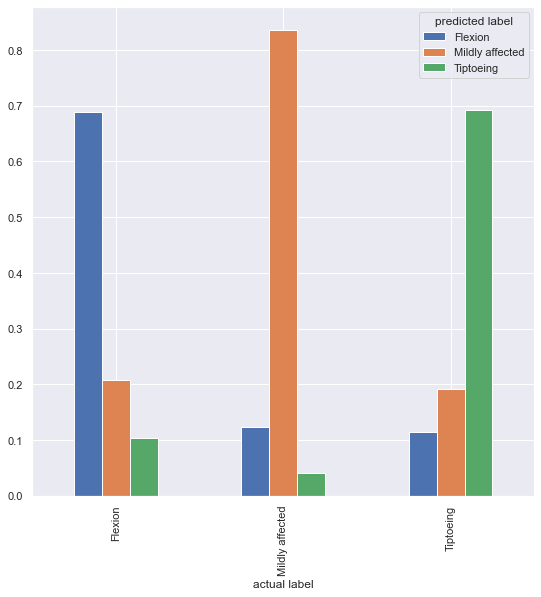

In [38]:
(pd.crosstab(df_predictions['actual label'],df_predictions['predicted label'], 
             normalize='index')
   .plot.bar(stacked=False)
)

# Tree SHAP explainer on reduced model

In [39]:
# minmax scaling 
scaler = MinMaxScaler()
X_reduced_scaled_array = scaler.fit_transform(X_reduced)
X_reduced_scaled = pd.DataFrame(X_reduced_scaled_array, columns = X_reduced.columns)

## Global explanations

#### 1) retrain reduced model on all datapoints

In [40]:
# train the random forest classifier on all datapoints together
model.fit(X_reduced_scaled, y) 
# predict the probabilities of each (seen) observation of the dataset
predicted_probabilities_2 = model.predict_proba(X_reduced_scaled)

In [41]:
# construct a dataframe to evaluate the predictions
prediction_data_2 = {
    'Measurement_id': df['Measurement_id'],
    'Patient_id': df['Patient_id'],
    "actual label": y,
    "Mildly affected": predicted_probabilities_2[:,1],
    "Tiptoeing": predicted_probabilities_2[:,2],
    "Flexion": predicted_probabilities_2[:,0]
}
df_predictions_2 = pd.DataFrame(prediction_data_2)

# the predicted label is the gait pattern with the highest predicted probability
df_predictions_2['predicted label'] = df_predictions_2[['Mildly affected','Tiptoeing','Flexion']].idxmax(axis=1)

# show the first observations
df_predictions_2.head()

,Measurement_id,Patient_id,actual label,Mildly affected,Tiptoeing,Flexion,predicted label
0,DMD0001_M1,DMD0001,Mildly affected,0.48,0.13,0.39,Mildly affected
1,DMD0001_M1,DMD0001,Mildly affected,0.41,0.09,0.50,Flexion
2,DMD0001_M2,DMD0001,Flexion,0.18,0.06,0.76,Flexion
3,DMD0001_M2,DMD0001,Flexion,0.12,0.07,0.81,Flexion
4,DMD0001_M3,DMD0001,Flexion,0.11,0.02,0.87,Flexion


In [42]:
# performance results on the training set
evaluate_predicted_labels(df_predictions_2) 

accuracy score:
0.927
precision scores:
[0.82222222 0.98089172 0.96296296]
recall scores:
[0.96103896 0.9005848  1.        ]
F1 scores:
[0.88622754 0.93902439 0.98113208]
F1 macro:
0.9354613368752599
F1 micro:
0.927007299270073
F1 weighted:
0.9281829403359683


#### 2) check expected probabilities of the reference group (total population) -> will serve as baseline probabilities for SHAP

In [43]:
df_predictions_2['Mildly affected'].mean()

0.4625912408759126

In [44]:
df_predictions_2['Tiptoeing'].mean()

0.20609489051094906

In [45]:
df_predictions_2['Flexion'].mean()

0.3313138686131387

#### 3) create tree SHAP explainer

In [46]:
# create SHAP explainer, reference group = all datapoints (default)
explainer_1 = shap.TreeExplainer(model)
# calculate shapley values
shap_values_1 = explainer_1.shap_values(X_reduced_scaled)

#### 4) plot global feature importances

Text(0.5, 0, 'mean(|SHAP value|)(average impact on probability of gait pattern)')

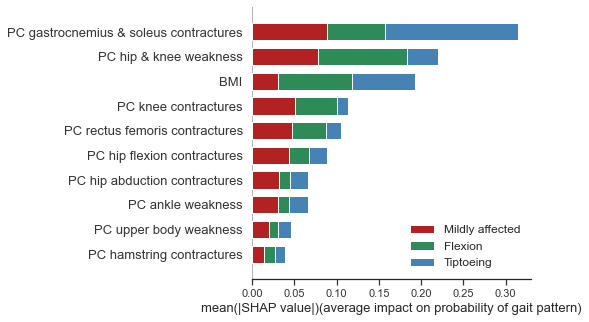

In [47]:
# get class ordering from shap values (for colors)
class_inds = np.argsort([-np.abs(shap_values_1[i]).mean() for i in range(len(shap_values_1))])

# create listed colormap
cmap = matplotlib.colors.ListedColormap(np.array(["seagreen","firebrick", "steelblue"])[class_inds])

# plot
sns.set_theme(style='white')
shap.summary_plot(shap_values_1, X_reduced_scaled, class_names = ['Flexion', 'Mildly affected', 'Tiptoeing'], color = cmap, show=False, plot_size=[5,5])
plt.xlabel("mean(|SHAP value|)(average impact on probability of gait pattern)")

Text(0.5, 0, 'mean(|SHAP value|)(average impact on probability of gait pattern)')

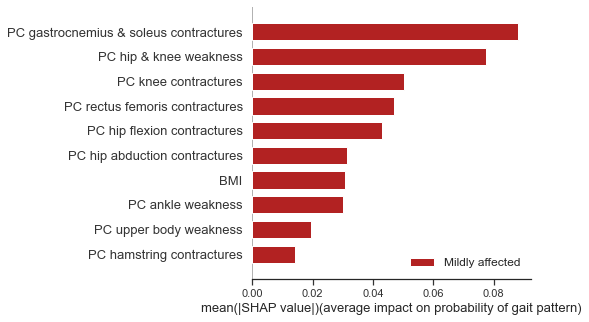

In [48]:
cmap = matplotlib.colors.ListedColormap(np.array(["firebrick"]))
sns.set_theme(style='white')
shap.summary_plot(shap_values_1[1:2], features=X_reduced_scaled, class_names = ['Mildly affected'], show=False, color = cmap, plot_size=[5,5])
plt.xlabel("mean(|SHAP value|)(average impact on probability of gait pattern)")

Text(0.5, 0, 'mean(|SHAP value|)(average impact on probability of gait pattern)')

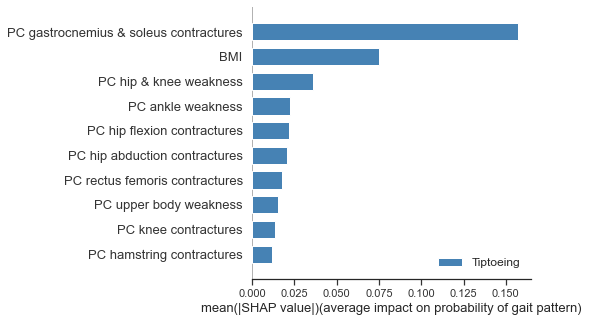

In [49]:
cmap = matplotlib.colors.ListedColormap(np.array(["steelblue"]))
sns.set_theme(style='white')
shap.summary_plot(shap_values_1[2:3], features=X_reduced_scaled, class_names = ['Tiptoeing'], show=False, color = cmap, plot_size=[5,5])
plt.xlabel("mean(|SHAP value|)(average impact on probability of gait pattern)")

Text(0.5, 0, 'mean(|SHAP value|)(average impact on probability of gait pattern)')

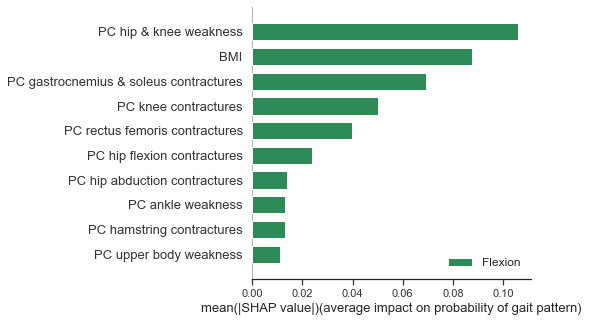

In [50]:
cmap = matplotlib.colors.ListedColormap(np.array(["seagreen"]))
sns.set_theme(style='white')
shap.summary_plot(shap_values_1[0:1], features=X_reduced_scaled, class_names = ['Flexion'], show=False, color = cmap, plot_size=[5,5])
plt.xlabel("mean(|SHAP value|)(average impact on probability of gait pattern)")

#### 5) generate summary plots

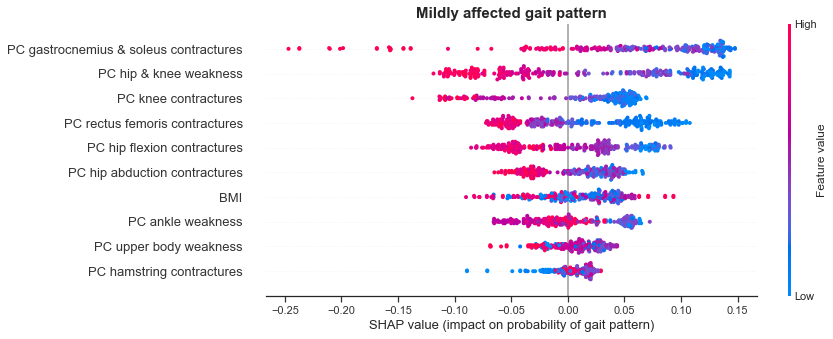

In [51]:
sns.set_theme(style='white')
shap.summary_plot(shap_values_1[1], features=X_reduced_scaled, show=False, plot_size=[11,5])
plt.title("Mildly affected gait pattern",fontsize=15, fontweight="bold")
plt.gcf().axes[-1].set_aspect(100)
plt.gcf().axes[-1].set_box_aspect(100)
plt.xlabel("SHAP value (impact on probability of gait pattern)")
plt.show()

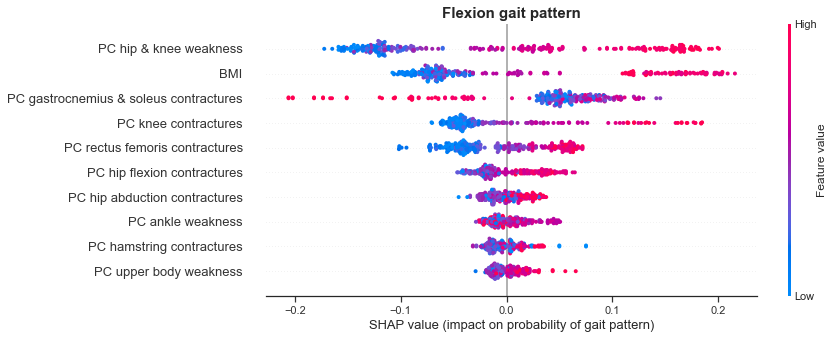

In [52]:
sns.set_theme(style='white')
shap.summary_plot(shap_values_1[0], features=X_reduced_scaled, show=False, plot_size=[11,5]) 
plt.title("Flexion gait pattern",fontsize=15, fontweight="bold")
plt.gcf().axes[-1].set_aspect(100)
plt.gcf().axes[-1].set_box_aspect(100)
plt.xlabel("SHAP value (impact on probability of gait pattern)")
plt.show()

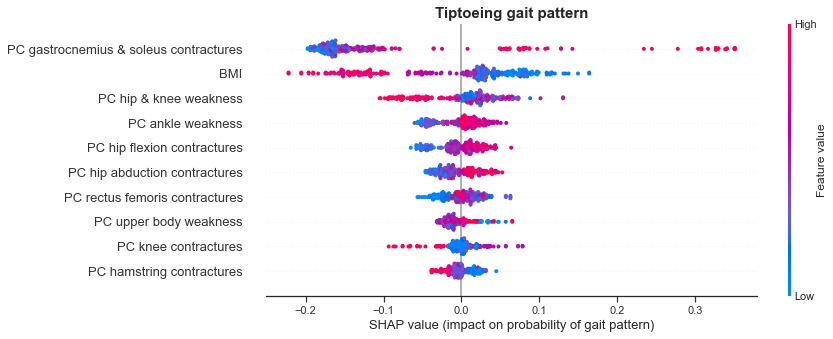

In [53]:
sns.set_theme(style='white')
shap.summary_plot(shap_values_1[2], features=X_reduced_scaled, show=False, plot_size=[11,5])
plt.title("Tiptoeing gait pattern",fontsize=15, fontweight="bold")
plt.gcf().axes[-1].set_aspect(100)
plt.gcf().axes[-1].set_box_aspect(100)
plt.xlabel("SHAP value (impact on probability of gait pattern)")
plt.show()

## Local explanations

#### 1) retrain reduced model on all datapoints except on the observations of the patient in question

In [54]:
# choose which measurement and which side
Measurement_id_ptA = 'DMD0001_MD2'
Measurement_id_ptB = 'DMD0001_M8'
Side_pt = 'LEFT'

# 
Patient_id_pt = df.loc[df['Measurement_id'] == Measurement_id_ptA]['Patient_id'].values[0]
X_reduced_train = X_reduced_scaled.loc[(df['Patient_id']!=Patient_id_pt)]                            # training features
y_train = y.loc[(df['Patient_id']!=Patient_id_pt)]                                                   # training target
obs_ptA = X_reduced_scaled.loc[(df['Measurement_id']==Measurement_id_ptA)& (df['side']==Side_pt)]    # test features obs A
obs_ptB = X_reduced_scaled.loc[(df['Measurement_id']==Measurement_id_ptB)& (df['side']==Side_pt)]    # test features obs B
y_ptA = y.loc[(df['Measurement_id']==Measurement_id_ptA) & (df['side']==Side_pt)]                    # test target obs A
y_ptB = y.loc[(df['Measurement_id']==Measurement_id_ptB) & (df['side']==Side_pt)]                    # test target obs B

In [55]:
# train the random forest classifier
model.fit(X_reduced_train, y_train)  

BalancedRandomForestClassifier()

#### 2) predict on observation A & B

In [56]:
# predict the probabilities of observations A and B
predicted_probabilities_ptA = model.predict_proba(obs_ptA)
predicted_probabilities_ptB = model.predict_proba(obs_ptB)

In [57]:
# construct a dataframe to evaluate the predictions of observation A
prediction_data_ptA = {
    'Patient_id': Patient_id_pt,
    'Measurement_id': Measurement_id_ptA,
    "actual label": y_ptA,
    "Mildly affected": predicted_probabilities_ptA[:,1],
    "Tiptoeing": predicted_probabilities_ptA[:,2],
    "Flexion": predicted_probabilities_ptA[:,0]
}
df_predictions_ptA = pd.DataFrame(prediction_data_ptA)

# the predicted label is the gait pattern with the highest predicted probability
df_predictions_ptA['predicted label'] = df_predictions_ptA[['Mildly affected','Tiptoeing','Flexion']].idxmax(axis=1)

In [58]:
# construct a dataframe to evaluate the predictions of observation B
prediction_data_ptB = {
    'Patient_id': Patient_id_pt,
    'Measurement_id': Measurement_id_ptB,
    "actual label": y_ptB,
    "Mildly affected": predicted_probabilities_ptB[:,1],
    "Tiptoeing": predicted_probabilities_ptB[:,2],
    "Flexion": predicted_probabilities_ptB[:,0]
}
df_predictions_ptB = pd.DataFrame(prediction_data_ptB)

# the predicted label is the gait pattern with the highest predicted probability
df_predictions_ptB['predicted label'] = df_predictions_ptB[['Mildly affected','Tiptoeing','Flexion']].idxmax(axis=1)

#### 3) create tree SHAP explainer & calculate shap values

In [59]:
# create SHAP explainer, reference group =  datapoints of the mildly affected gait pattern
explainer_pt = shap.TreeExplainer(model, data = X_reduced_train.loc[y=='Mildly affected'])
# calculate shapley values
shap_values_ptA = explainer_pt(obs_ptA)
shap_values_ptB = explainer_pt(obs_ptB)

#### 4) plot global feature importances

In [60]:
# check prediction observation A
df_predictions_ptA

,Patient_id,Measurement_id,actual label,Mildly affected,Tiptoeing,Flexion,predicted label
16,DMD0001,DMD0001_MD2,Mildly affected,0.59,0.07,0.34,Mildly affected


In [61]:
# check prediction observation B
df_predictions_ptB

,Patient_id,Measurement_id,actual label,Mildly affected,Tiptoeing,Flexion,predicted label
14,DMD0001,DMD0001_M8,Flexion,0.11,0.23,0.66,Flexion


In [62]:
# check baseline probabilities
shap_values_ptA.base_values

array([[0.181 , 0.7062, 0.1128]])

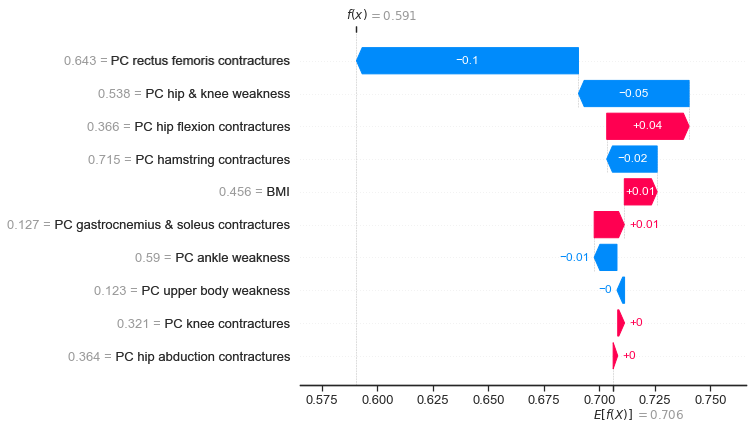

In [63]:
# mildly affected gait pattern (observation A)
waterfall = shap.plots.waterfall(shap_values_ptA[0,:,1])

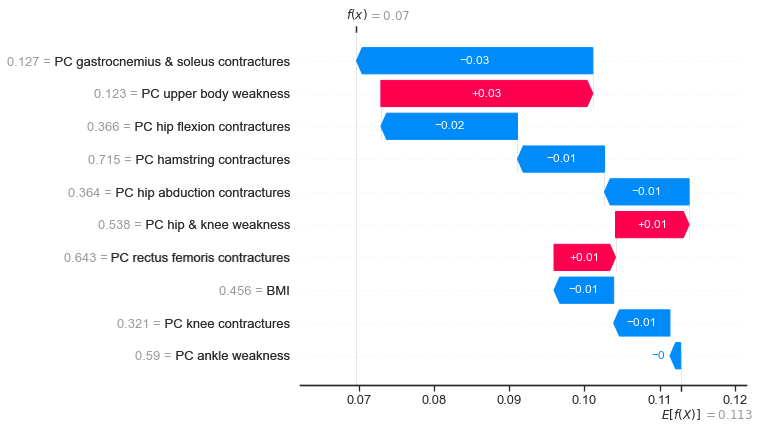

In [64]:
# tiptoeing gait pattern (observation A)
waterfall = shap.plots.waterfall(shap_values_ptA[0,:,2])

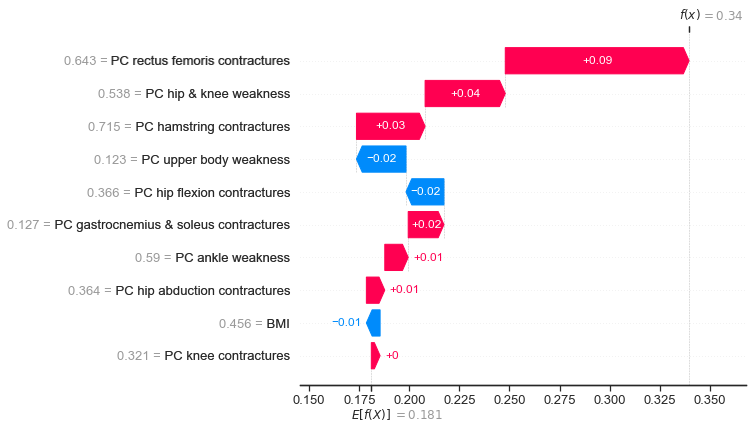

In [65]:
# flexion gait pattern (observation A)
waterfall = shap.plots.waterfall(shap_values_ptA[0,:,0])

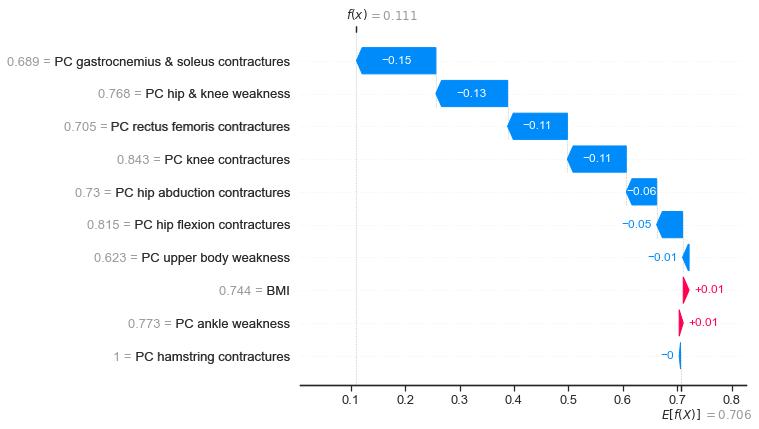

In [66]:
# mildly affected gait pattern (observation B)
waterfall = shap.plots.waterfall(shap_values_ptB[0,:,1])

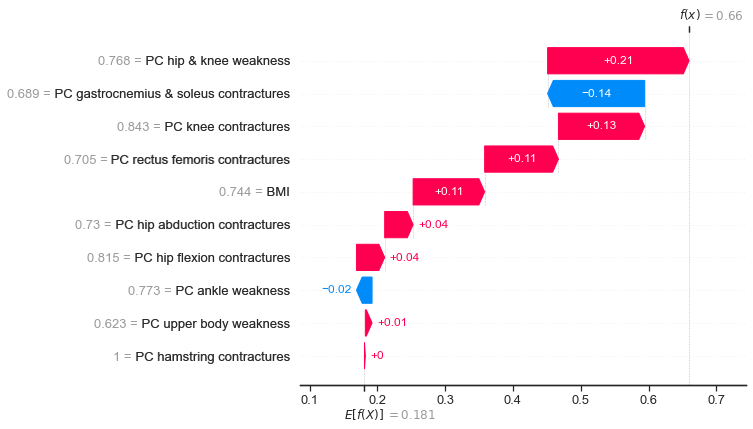

In [67]:
# flexion gait pattern (observation B)
waterfall = shap.plots.waterfall(shap_values_ptB[0,:,0])